In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

/Users/mandar/SJSU/CS271 Topics in ML/HW2/denoising_autoencoder/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
# load and normalize cifar data
(x_train, _), (x_test, _) = cifar10.load_data()

# Normalize to [0, 1]
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

In [4]:
# Convert RGB to Grayscale as input, keep RGB as target
x_train_gray = tf.image.rgb_to_grayscale(x_train)
x_test_gray = tf.image.rgb_to_grayscale(x_test)

print("Input (gray):", x_train_gray.shape)
print("Target (RGB):", x_train.shape)

Input (gray): (50000, 32, 32, 1)
Target (RGB): (50000, 32, 32, 3)


In [5]:
# define colorization model
input_img = Input(shape=(32, 32, 1))  # Grayscale input

# -------- Encoder --------
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)       # 32x32x64
x = Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(x)    # 16x16x64
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)              # 16x16x128
x = Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(x)   # 8x8x128

encoded = x

# -------- Decoder --------
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)              # 8x8x128
x = UpSampling2D((2, 2))(x)                                                # 16x16x128
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)               # 16x16x64
x = UpSampling2D((2, 2))(x)                                                # 32x32x64
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)               # 32x32x32

# Output: RGB prediction (3 channels)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)        # 32x32x3

colorization_model = Model(input_img, decoded)

In [6]:
colorization_model.compile(optimizer='adam', loss='mse')
colorization_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 499,715 (1.91 MB)

 Trainable params: 499,715 (1.91 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = colorization_model.fit(
    x_train_gray, x_train,
    epochs=30,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_gray, x_test)
)

Epoch 1/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 104s 265ms/step - loss: 0.0033 - val_loss: 0.0060
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 115s 294ms/step - loss: 0.0033 - val_loss: 0.0059
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 129s 331ms/step - loss: 0.0033 - val_loss: 0.0059
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 128s 328ms/step - loss: 0.0032 - val_loss: 0.0063
Epoch 5/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 129s 330ms/step - loss: 0.0032 - val_loss: 0.0063
Epoch 6/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 130s 333ms/step - loss: 0.0032 - val_loss: 0.0059
Epoch 7/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 130s 332ms/step - loss: 0.0031 - val_loss: 0.0059
Epoch 8/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 122s 312ms/step - loss: 0.0032 - val_loss: 0.0061
Epoch 9/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 121s 311ms/step - loss: 0.0031 - val_loss: 0.0062
Epoch 10/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 124s 317ms/step - loss: 0.0031 - val_loss: 0.0063
Epoch 11/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 121s 310ms/step - loss: 0.0031 - val_loss: 0.0059
Epoch 12

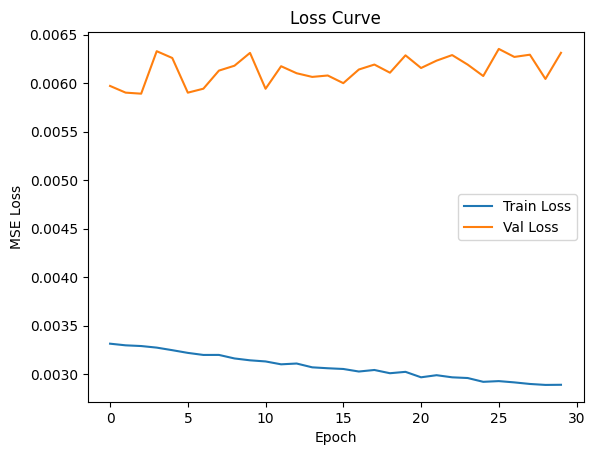

In [15]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


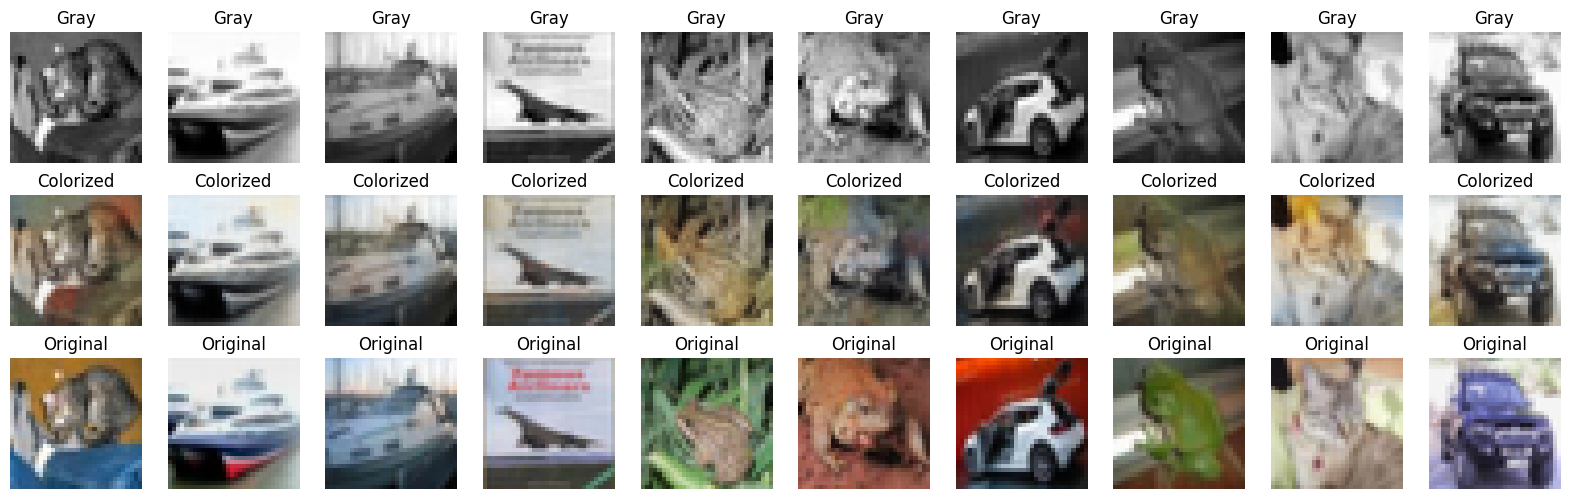

In [16]:
predicted_color = colorization_model.predict(x_test_gray[:10])

n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # Grayscale Input
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_gray[i].numpy().squeeze(), cmap='gray')
    plt.title("Gray")
    plt.axis('off')

    # Colorized Output
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(predicted_color[i])
    plt.title("Colorized")
    plt.axis('off')

    # Original RGB
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(x_test[i])
    plt.title("Original")
    plt.axis('off')
plt.show()
